# Use this notebook to make difference plots with wrfout files for various ensembles

## Notebook compiled by Jeremiah Otero
## Adapted from Steve Nesbitt's wrf_plot_FULL_domain.py
Link: https://github.com/swnesbitt/wrfplotting/blob/master/wrf_plot_FULL_domain.py

In [48]:
## Bring in the important stuff!

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import sys, os
import xarray as xr
import math

from netCDF4 import Dataset
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from pandas import Timestamp
from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords, extract_times, ALL_TIMES, interplevel
from glob import glob
from osgeo import ogr, osr

mpl.use('Agg')
%matplotlib inline

ImportError: No module named osgeo

In [15]:
## Make fonts look nice

mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.style'] = 'normal'

In [32]:
## Define some important landmarks

def landmarks():
    landmark_dict = {'C':(-64.2123,-31.3154)}
                    #'M':(-68.7987,-32.8278),
                    #'3':(-64.1131,-32.1767),
                    #'4':(-64.34992,-33.13067), 
                    #'Y':(-64.7545,-32.1062),
                    #'S':(-63.978435,-31.715689),
                    #'SR':(-68.285522,-34.587997),
                    #'SL':(-66.33694,-33.30278)}
    return landmark_dict

landmark_dict=landmarks()

In [33]:
## Select zoom
## available options are: 'fullest' , full' , 'cordoba_zoom' , 'mendoza_zoom'

zoom='fullest'

titlestr='GFS-WRF' # create title for figure purposes
modname='GFS' # identify model for figure purposes

# select stage of life cycle

#stage = 'early'
#stage = 'mature'
stage = 'late'

## Select ensemble run
## available options are: 'wrfout_8_2' , 'wrfout_10_2'

## named based on ensemble physical parameterizations - edits to namelist.input
    ## mp_physics: 8 = Thompson; 10 = Morrison; 17 = NSSL
    ## bl_pbl_physics: 1 = YSU; 2 = MYJ

#ensemble='wrfout_17_1' # change this right here

#if ensemble is 'wrfout_8_2':
 #   titl_ensemble='Thompson-MYJ'
#if ensemble is 'wrfout_10_2':
 #   titl_ensemble='Morrison-MYJ'
#if ensemble is 'wrfout_17_2':
 #   titl_ensemble='NSSL-MYJ'
#if ensemble is 'wrfout_8_1':
 #   titl_ensemble='Thompson-YSU'
#if ensemble is 'wrfout_10_1':
#    titl_ensemble='Morrison-YSU'
#if ensemble is 'wrfout_17_1':
 #   titl_ensemble='NSSL-YSU'

In [34]:
## Bring in wrfout data as 'filenames'

path = '/glade/work/jpiers/WRFV3/run/wrfout_diffs/'+stage # set path to where wrfout files are located
filenames = sorted(glob(path+'/*')) # define filenames, sorted by time

In [35]:
print(filenames)

['/glade/work/jpiers/WRFV3/run/wrfout_diffs/late/lat_08_2_10_2_2016-12-27_04:00:00', '/glade/work/jpiers/WRFV3/run/wrfout_diffs/late/lat_08_2_17_2_2016-12-27_04:00:00', '/glade/work/jpiers/WRFV3/run/wrfout_diffs/late/lat_17_2_10_2_2016-12-27_04:00:00']


In [36]:
## Create lists 'files' and 'times' that will be used for making plots
## Print times - for diagnostic purposes

files=[]
times=[]
stage_name=[]

for file in filenames:
    files.append(Dataset(file))
    stage_name_str = os.path.basename(file)[:14]
    #print(os.path.basename(file)[:14])
    #print(stage_name_str)
    stage_name.append(stage_name_str)
    times.append(pd.to_datetime(os.path.basename(file)[14:],format='%Y-%m-%d_%H:%M:%S'))

In [37]:
print(stage_name)

['lat_08_2_10_2_', 'lat_08_2_17_2_', 'lat_17_2_10_2_']


In [44]:
## Define function 'make_plot'

def make_plot(cffield,lfield,lfield2,ufld,vfld,params):
# Get the latitude and longitude points

    print(params['time_index'])
    
    lats, lons = latlon_coords(cffield)

    # Get the basemap object

    if params['zoom'] == 'fullest':
        bm = Basemap(projection='lcc',width=5400*550,height=6400*375,
        resolution='i',lat_1=-32.0,lat_2=-32.0,lat_0=-32.0,lon_0=-65.25)
        fs=15
        params['skip']=30
    
    if params['zoom'] == 'full':
        bm = Basemap(projection='lcc',width=3000*550,height=3000*375,
        resolution='i',lat_1=-32.8,lat_2=-32.8,lat_0=-32.8,lon_0=-67.0)
        fs=12
        params['skip']=17

    if params['zoom'] == 'cordoba_zoom':
        bm = Basemap(projection='lcc',width=1500*550,height=1500*375,
        resolution='i',lat_1=-32.2,lat_2=-32.2,lat_0=-32.2,lon_0=-65.0)
        fs=14 
        params['skip']=9
    
    if params['zoom'] == 'mendoza_zoom':
        bm = Basemap(projection='lcc',width=1500*550,height=1500*375,
        resolution='i',lat_1=-33.2,lat_2=-33.2,lat_0=-33.2,lon_0=-69.0)
        fs=14 
        params['skip']=9

    # Create a figure
    fig = plt.figure(figsize=(12,9))

    # Add geographic outlines
    bm.drawcoastlines(linewidth=0.75)
    #bm.drawstates(linewidth=1.)
    bm.drawcountries(linewidth=1.)

    # Convert the lats and lons to x and y.  Make sure you convert the lats and lons to
    # numpy arrays via to_np, or basemap crashes with an undefined RuntimeError.
    x, y = bm(to_np(lons), to_np(lats))


    if lfield is not None:
        CS=bm.contour(x, y, to_np(lfield), 10, colors="black", levels=params['llevels'],linewidths=1.0)
        plt.clabel(CS, inline=1, fontsize=12, fmt='%d')

    if lfield2 is not None:
        CS=bm.contour(x, y, to_np(lfield2), 10, colors="dimgrey", levels=params['llevels2'],linewidths=2.25)
        #plt.clabel(CS, inline=1, fontsize=12, fmt='%d')
    
    if ufld is not None:
        bm.barbs(x[::params['skip'],::params['skip']], 
                 y[::params['skip'],::params['skip']], 
                 to_np(ufld[::params['skip'],::params['skip']]),
                 to_np(vfld[::params['skip'],::params['skip']]), length=5, linewidth=0.75, zorder=10)


    if not('lalpha' in params):
        params['lalpha']=None
        

    # Draw the contours and filled contours
    bm.contourf(x, y, to_np(cffield), 10, cmap=get_cmap(params['ccmap']), levels=params['clevels'], extend='both',
               alpha=params['lalpha'])

    
    if zoom is 'fullest':
        parallels = np.arange(-50.,-10.,5.)
        meridians = np.arange(-90.,-45.,5.)
    else:    
        parallels = np.arange(-50.,-10.,2.)
        meridians = np.arange(-90.,-46.,2.)
    
    # labels = [left,right,top,bottom]
    bm.drawparallels(parallels,labels=[False,True,False,False],linewidth=0.5,dashes=[2,2])
    bm.drawmeridians(meridians,labels=[False,False,False,True],linewidth=0.5,dashes=[2,2])

    # Add a color bar
    plt.colorbar(shrink=.62, extend='both')

    timediff=params['times'][params['time_index']]-params['times'][0]
    timediff_secs=int(timediff.total_seconds()//3600)

    plt.title(titlestr+': Late 2 m Temp Difference ('+cffield.units+') '+stage_name[i]+'\n'+
             "Initialized: 2016-12-25 00:00Z Forecast hour: 52 Valid: "+params['times'][params['time_index']].strftime('%Y-%m-%d %H:%M')+'Z')

    for key in landmark_dict.keys():
        kx,ky=bm(landmark_dict[key][0],landmark_dict[key][1])
        plt.text(kx,ky,key, fontsize=fs,
                        ha='center',va='center',color='w')
        
    #fig.figimage(im, fig.bbox.xmax-290, fig.bbox.ymin,zorder=10)


## Make and save plots!
See Nesbitt's code, as named above, to bring in the params for different variables. Some modifications necessary, as outlined below.

0
1
2


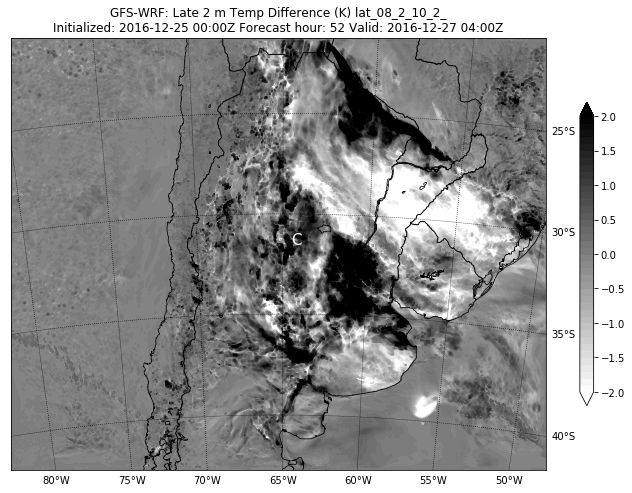

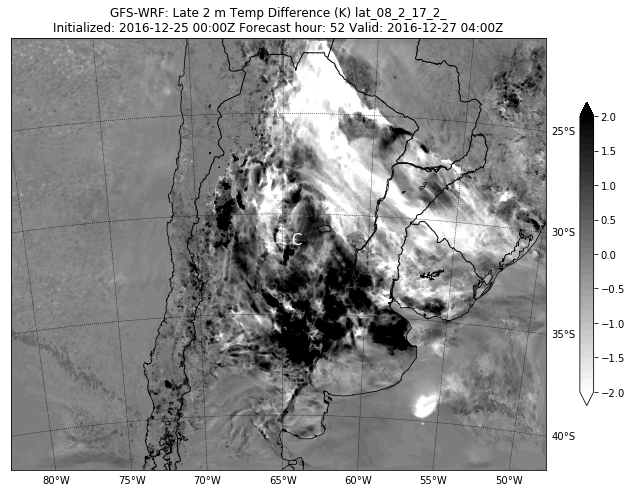

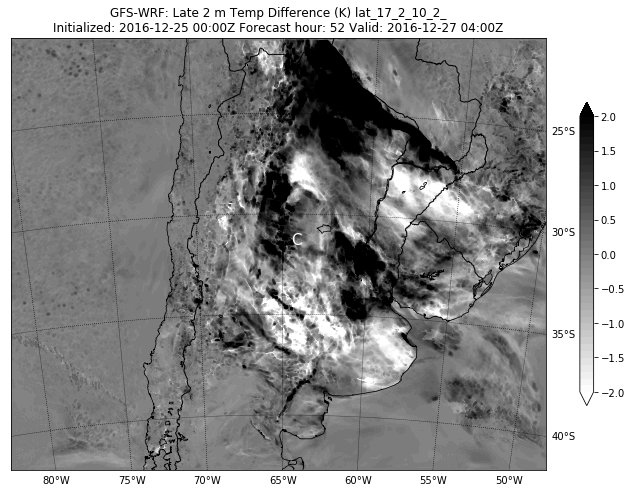

In [47]:
#=====================2 M TEMP=========================
# black and white
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters!

outpath = 'DEC16_images/diffs/'+stage+'/T2' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>3:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'2m_Temperature',
            'cfield':'T2',
            'clevels':np.arange(-2,2.1,.1),
            'ccmap':"binary",
            'llevels':np.arange(970,1040,4),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'],units='degC')
    cffield.attrs['description']='2 m temperature difference'
    cffield.attrs['temperature']='degC'
    #cffield.values=cffield.values-273.15
    #lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    #uvmet = None
    #ufld = uvmet.isel(u_v=0)
    ufld = None
    vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    plt.savefig(outpath+'/'+zoom+'_T2_bw'+stage_name[i]+'.eps', bbox_inches="tight", dpi=200)

0
1
2


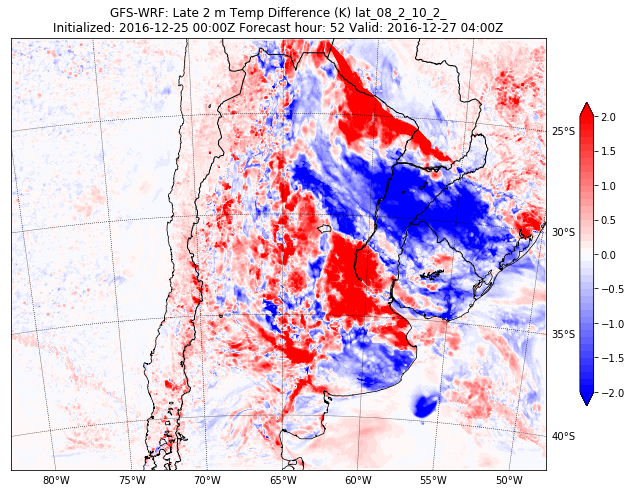

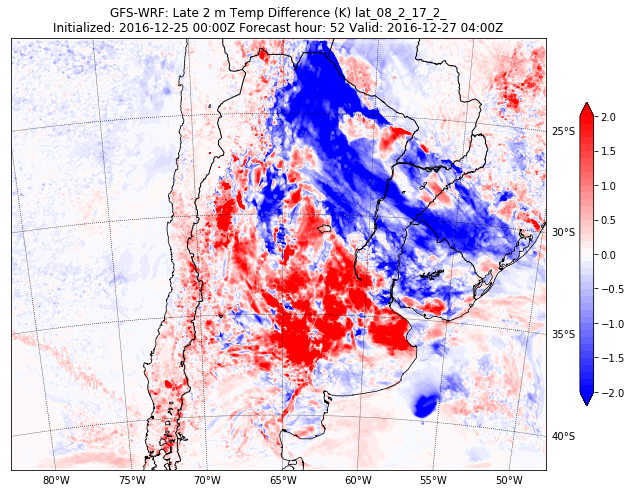

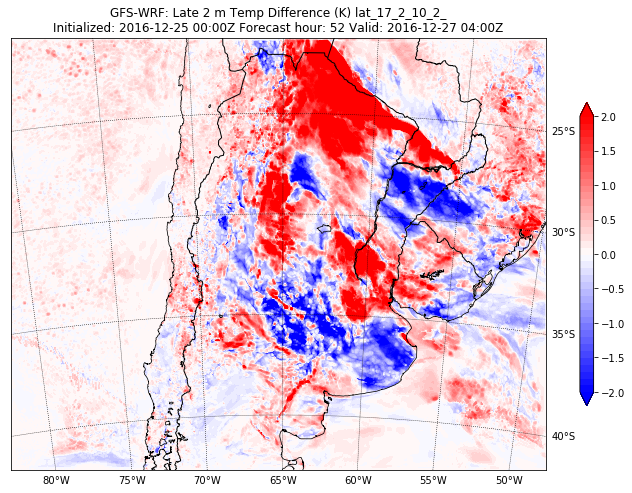

In [26]:
#=====================2 M TEMP=========================
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters!

outpath = 'DEC16_images/diffs/'+stage+'/T2' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>3:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'2m_Temperature',
            'cfield':'T2',
            'clevels':np.arange(-2,2.1,.1),
            'ccmap':"bwr",
            'llevels':np.arange(970,1040,4),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'],units='degC')
    cffield.attrs['description']='2 m temperature difference'
    cffield.attrs['temperature']='degC'
    #cffield.values=cffield.values-273.15
    #lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    #uvmet = None
    #ufld = uvmet.isel(u_v=0)
    ufld = None
    vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    plt.savefig(outpath+'/'+zoom+'_T2_'+stage_name[i]+'.png', bbox_inches="tight", dpi=200)

0


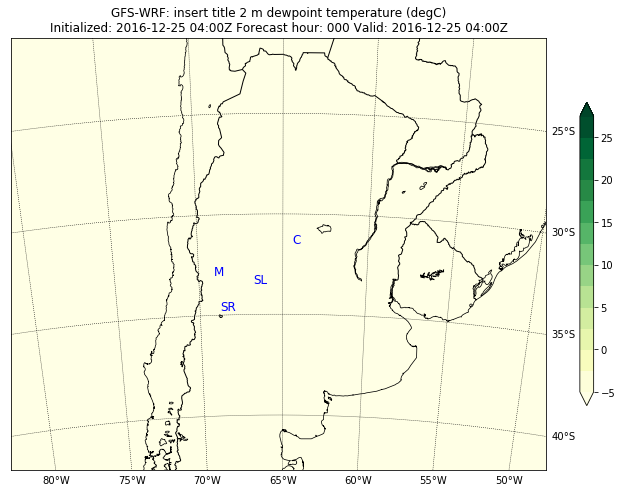

In [37]:
#=====================2 M DWPT=========================
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/diff/td2' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>61:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'2m_Dewpoint_Temperature',
            'cfield':'td2',
            'clevels':np.arange(-5,30,2.5),
            'ccmap':"bwr",
            'llevels':np.arange(970,1040,4),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    cffield.attrs['description']='2 m dewpoint temperature'
    cffield.attrs['temperature']='degC'
    cffield.values=cffield.values
    #lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    #ufld = uvmet.isel(u_v=0)
    ufld = None
    vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    plt.savefig(outpath+'/'+zoom+'_td2_early_8_2_10_2_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

In [38]:
print(cffield.values)

[[-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]
 [-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]
 [-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]
 ..., 
 [-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]
 [-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]
 [-80.44786072 -80.44786072 -80.44786072 ..., -80.44786072 -80.44786072
  -80.44786072]]


0


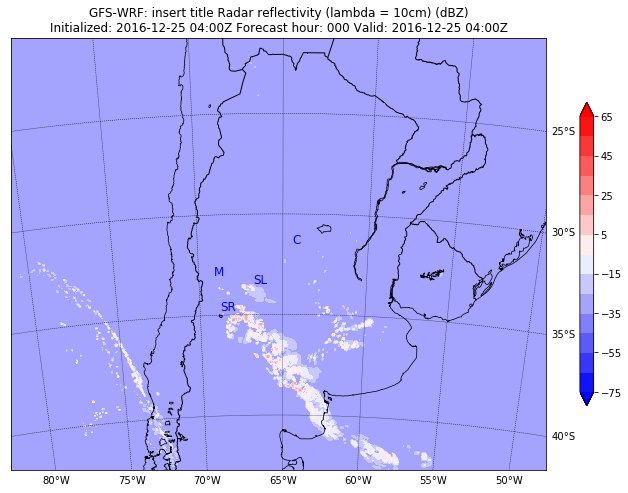

In [34]:
#=========================Radar Reflectivity (lambda=10cm)=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/diffs/refl' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>61:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Radar Reflectivity (lambda = 10cm)',
            'cfield':'REFL_10CM',
            'clevels':np.arange(-75,75,10),
            'ccmap':"bwr",
            'llevels':np.arange(510,606,6),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    dbz = getvar(files, 'dbz', timeidx=params['time_index'])
    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")

    ter_3d=np.tile(ter.values,[41,1,1])
    #z.values=z.values-ter.values
    #cffield = interplevel(dbz, z, 1000)
    cffield = xr.DataArray(np.max(dbz.values, axis=0), coords=dbz.coords, dims=dbz.dims[1:],attrs=dbz.attrs)
    #cffield.values=np.ma.masked_less(cffield.values,5.)
    cffield.attrs['description']='Radar reflectivity (lambda = 10cm)'
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    ufld=None
    vfld=None

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)

## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    plt.savefig(outpath+'/'+zoom+'_refl_early_8_2_10_2_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)